Answers:  
1) "ocean_proximity"
2) 0.245
3) 160
4) 25
5) median_income
6) 0.3

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeRegressor, export_text
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

import xgboost as xgb

# Loading data

In [2]:
df = pd.read_csv("housing.csv")

In [3]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


# Data processing

In [4]:
limited_df = df[df.ocean_proximity.isin(["<1H OCEAN", "INLAND"])]
limited_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
701,-121.97,37.64,32.0,1283.0,194.0,485.0,171.0,6.0574,431000.0,<1H OCEAN
830,-121.99,37.61,9.0,3666.0,711.0,2341.0,703.0,4.6458,217000.0,<1H OCEAN
859,-121.97,37.57,21.0,4342.0,783.0,2172.0,789.0,4.6146,247600.0,<1H OCEAN
860,-121.96,37.58,15.0,3575.0,597.0,1777.0,559.0,5.7192,283500.0,<1H OCEAN
861,-121.98,37.58,20.0,4126.0,1031.0,2079.0,975.0,3.6832,216900.0,<1H OCEAN


Filling NaNs:

In [5]:
limited_df = limited_df.fillna(0)

In [6]:
limited_df.isna().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

Taking the logarithm of the "median_house_value" column:

<AxesSubplot:>

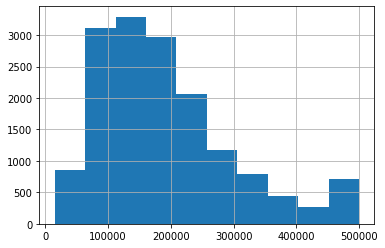

In [7]:
limited_df.median_house_value.hist()

In [8]:
limited_df.median_house_value = np.log1p(limited_df.median_house_value)

<AxesSubplot:>

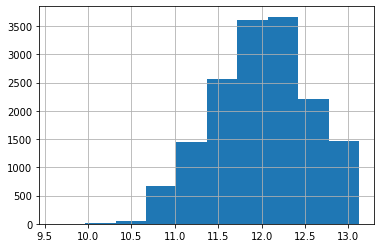

In [9]:
limited_df.median_house_value.hist()

Splitting the data:

In [10]:
X = limited_df.drop(columns=["median_house_value"], axis=1)
y = limited_df["median_house_value"]

In [11]:
X_full_train, X_test, y_full_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_full_train, y_full_train, test_size=0.25, random_state=1)

print("Full_train size:\n", X_full_train.shape[0], y_full_train.shape[0])
print("Test size:\n", X_test.shape[0], y_test.shape[0])
print("Train size:\n", X_train.shape[0], y_train.shape[0])
print("Validation size:\n", X_val.shape[0], y_val.shape[0])

Full_train size:
 12549 12549
Test size:
 3138 3138
Train size:
 9411 9411
Validation size:
 3138 3138


Checking that data rations equal to 0.6|0.2|0.2:

In [12]:
X_test.shape[0] / (X_full_train.shape[0] + X_test.shape[0])

0.20003824823101932

In [13]:
X_val.shape[0] / (X_full_train.shape[0] + X_val.shape[0])

0.20003824823101932

In [14]:
X_train.shape[0] / (X_train.shape[0] + X_val.shape[0] + X_test.shape[0])

0.5999235035379614

___

In [15]:
dv = DictVectorizer(sparse=True)

dicts_full_train = X_full_train.to_dict(orient="records")
dicts_train = X_train.to_dict(orient="records")
dicts_val = X_val.to_dict(orient="records")
dicts_test = X_test.to_dict(orient="records")

X_full_train = dv.fit_transform(dicts_full_train)
X_train = dv.transform(dicts_train)
X_val = dv.transform(dicts_val)

# Training models

In [16]:
dtr = DecisionTreeRegressor(max_depth=1)

dtr.fit(X_train, y_train)
None

In [17]:
print(export_text(dtr, feature_names=dv.get_feature_names_out().tolist()))

|--- ocean_proximity=<1H OCEAN <= 0.50
|   |--- value: [11.61]
|--- ocean_proximity=<1H OCEAN >  0.50
|   |--- value: [12.30]



"ocean_proximity" is used for splitting the data

In [18]:
rfr = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)

rfr.fit(X_train, y_train)
val_preds = rfr.predict(X_val)

print("%.3f" % mean_squared_error(y_val, val_preds, squared=False))

0.245


In [19]:
estimators = np.arange(10, 201, 10)
rmses = []

rfr = RandomForestRegressor(
    n_estimators=1,
    random_state=1,
    n_jobs=-1,
    warm_start=True,
)

for e in tqdm(estimators):
    rfr.n_estimators = e
    rfr.fit(X_train, y_train)
    val_preds = rfr.predict(X_val)

    rmse = mean_squared_error(y_val, val_preds, squared=False)

    rmses.append([e, rmse])

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:40<00:00,  2.04s/it]


In [20]:
df_scores = pd.DataFrame(rmses, columns=["n_estimators", "rmse"])
df_scores.sort_values(by="rmse", ascending=False).head()

,n_estimators,rmse
0,10,0.245277
1,20,0.239041
2,30,0.236995
3,40,0.235509
4,50,0.235021


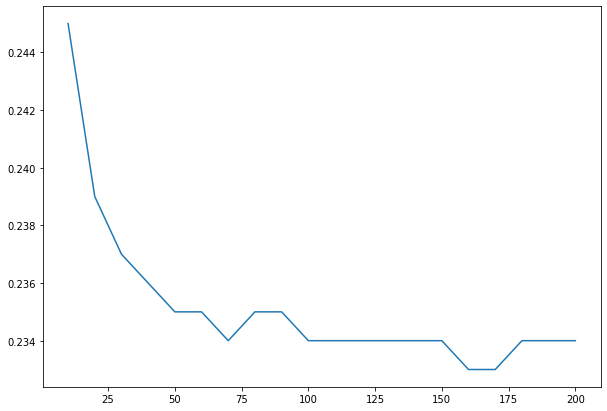

In [21]:
plt.figure(figsize=(10, 7))

plt.plot(df_scores.n_estimators, df_scores.rmse.round(3))

"n_estimators" = 160 shows the best RMSE, bigger values don't improve the score

In [22]:
estimators = np.arange(10, 201, 10)
max_depths = [10, 15, 20, 25]
rmses = []

for d in max_depths:
    rfr = RandomForestRegressor(
        n_estimators=1,
        max_depth=d,
        random_state=1,
        n_jobs=-1,
        warm_start=True,
    )
    
    for e in tqdm(estimators):
        rfr.n_estimators = e
        rfr.fit(X_train, y_train)
        val_preds = rfr.predict(X_val)
    
        rmse = mean_squared_error(y_val, val_preds, squared=False)
    
        rmses.append([d, e, rmse])

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:36<00:00,  1.84s/it]


In [23]:
df_scores = pd.DataFrame(rmses, columns=["max_depth", "n_estimators", "rmse"])
df_scores.sort_values(by="rmse", ascending=False).head()

,max_depth,n_estimators,rmse
0,10,10,0.250677
1,10,20,0.247672
2,10,30,0.246434
20,15,10,0.245772
7,10,80,0.245640


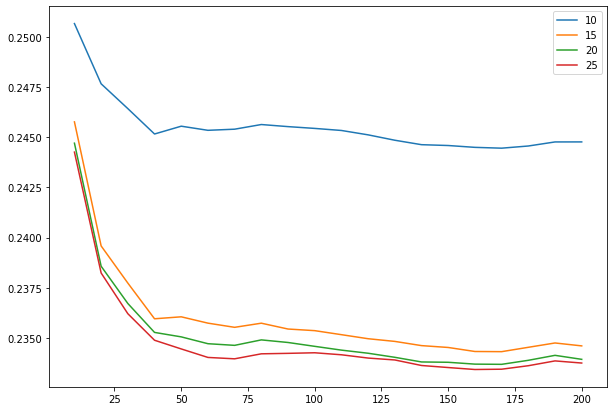

In [24]:
plt.figure(figsize=(10, 7))

for d in max_depths:
    df_depth = df_scores[df_scores.max_depth == d]
    plt.plot(df_depth.n_estimators, df_depth.rmse, label=d)

plt.legend()

Max_depth = 25 shows the best RMSE

___

In [25]:
rfr = RandomForestRegressor(
        n_estimators=10,
        max_depth=20,
        random_state=1,
        n_jobs=-1,
    )

rfr.fit(X_train, y_train)

rfr.feature_importances_

array([0.0151361 , 0.03031726, 0.10200703, 0.08624381, 0.33561113,
       0.29247297, 0.07380644, 0.02713606, 0.01585222, 0.02141699])

In [26]:
feature_importances = rfr.feature_importances_.round(3).tolist()
columns = dv.feature_names_

importance_df = pd.DataFrame(zip(columns, feature_importances), columns=["feature", "importance"])
importance_df.sort_values(by="importance", ascending=False)

,feature,importance
4,median_income,0.336
5,ocean_proximity=<1H OCEAN,0.292
2,latitude,0.102
3,longitude,0.086
6,ocean_proximity=INLAND,0.074
1,housing_median_age,0.030
7,population,0.027
9,total_rooms,0.021
8,total_bedrooms,0.016
0,households,0.015


Feature "median_income" has the most importance score

In [27]:
columns = [c.replace('<', "less") for c in columns]

In [28]:
dfull_train = xgb.DMatrix(X_full_train, label=y_full_train, feature_names=columns)
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=columns)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=columns)

In [29]:
watchlist = [[dtrain, "train"], [dval, "val"]]

In [30]:
%%capture output_eta_1

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [31]:
%%capture output_eta_2

xgb_params['eta'] = 0.1

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [32]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [33]:
df_score_eta_0_3 = parse_xgb_output(output_eta_1)
df_score_eta_0_1 = parse_xgb_output(output_eta_2)

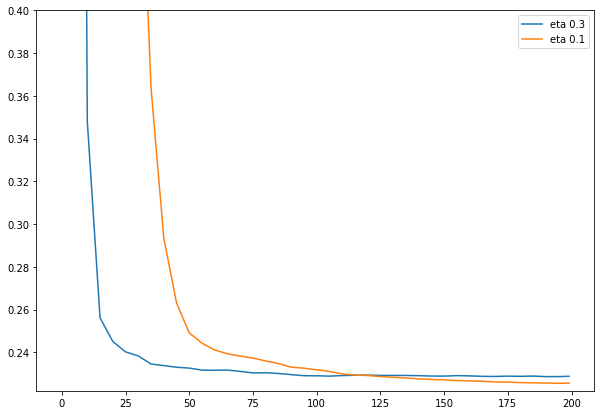

In [34]:
plt.figure(figsize=(10, 7))

plt.plot(df_score_eta_0_3.num_iter, df_score_eta_0_3.val_auc, label='eta 0.3')
plt.plot(df_score_eta_0_1.num_iter, df_score_eta_0_1.val_auc, label='eta 0.1')

plt.ylim([0.222, 0.4])
plt.legend()

Two different etas show close result. But eta=0.3 learns faster